In [1]:
import requests 
import json
import os
import sys
import time
import re
import sqlalchemy
import pandas as pd
import numpy as np
from math import log
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import matplotlib.pyplot as plt
%matplotlib inline

### RS with Collaborative Filtering
#### workflow
create rating_rdd = user_id, app_id, rating=log(time played+1)  
traing model with pyspark.mllib.recommendation.ALS  
make user or item based recommendation   
evaluate model  

In [ ]:
# sc.stop()

In [2]:
sc = SparkContext.getOrCreate()
def format_text(raw_string):
	user_inventory = json.loads(raw_string)
	return list(user_inventory.items())[0]

In [3]:
# init rdd
step1 = sc.textFile('user_play_events.txt')
# preprocess, load json 
step2 = step1.map(format_text)
# replace user_id with idx, otherwise got error in traing: Ratings id exceeds max integer
# value of 2147483647
step3 = step2.zipWithIndex()

In [32]:
step3.take(1) 
# format = [((use_id, [{},{},...]),idx),(),...]

[(('xxxx',
   [{'appid': 4000, 'playtime_2weeks': 49, 'playtime_forever': 370},
    {'appid': 110800, 'playtime_forever': 9},
    {'appid': 226320, 'playtime_forever': 0},
    {'appid': 250320, 'playtime_2weeks': 79, 'playtime_forever': 507},
    {'appid': 296470, 'playtime_2weeks': 68, 'playtime_forever': 78},
    {'appid': 301520, 'playtime_forever': 20},
    {'appid': 205790, 'playtime_forever': 0},
    {'appid': 730, 'playtime_2weeks': 114, 'playtime_forever': 5973},
    {'appid': 218620, 'playtime_forever': 54},
    {'appid': 352460, 'playtime_forever': 36},
    {'appid': 34270, 'playtime_forever': 0},
    {'appid': 205230, 'playtime_forever': 1},
    {'appid': 205950, 'playtime_forever': 0}]),
  0)]

In [4]:
# = user_id, app_id, rating=log(playtime_forever+1).StandardScaler()
def format_rating(events):
    ((user_id, play_events), idx) = events
    if play_events != None:
        try:
            return (idx, [(play_event.get('appid'), log(play_event.get('playtime_forever')+1)) for play_event in play_events])
        except:
            return (idx, []) # if pass cause TypeError: 'NoneType' object is not subscriptable 
    else:
        return (idx, [])

In [5]:
ratings = step3.map(format_rating).flatMapValues(lambda x: x)
rating_rdd = ratings.map(lambda l: Rating(int(l[0]), int(l[1][0]), float(l[1][1])))

In [69]:
# distribution of rating(log(time played))
n = rating_rdd.map(lambda x:x[2]).count()
rating_score = rating_rdd.map(lambda x:x[2]).take(n)

In [23]:
max(rating_score)

12.98329669328113

In [67]:
rating_score.count(log(1))

127229

Text(0,0.5,'count')

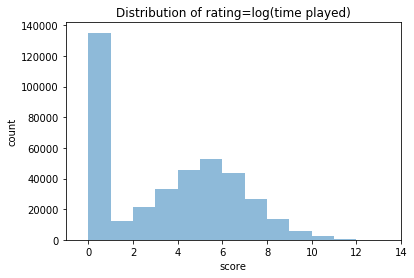

In [25]:
# hist plot
bins = np.arange(0, max(rating_score)+1, 1) # fixed bin size
plt.xlim([min(rating_score)-1, max(rating_score)+1])
plt.hist(rating_score, bins=bins, alpha=0.5)
plt.title('Distribution of rating=log(time played)')
plt.xlabel('score')
plt.ylabel('count')
# 1. many items not played
# 2. the rest part look like normal distribution, but shapiro test indicates no

In [81]:
from scipy import stats
x = list(filter(lambda a: a != log(1), rating_score))
y = list(filter(lambda a: a != log(2), x))
stats.shapiro(y)

/Users/YC/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9948904514312744, 0.0)

In [12]:
# distinct user
rating_rdd.map(lambda x:x[0]).distinct().count()

4460

In [16]:
# distinct game
rating_rdd.map(lambda x:x[1]).distinct().count()

7784

In [137]:
# build the recommendation model using ALS
rank = 10
numIterations = 10
model = ALS.train(rating_rdd, rank, numIterations) 

In [138]:
# recommand 5 games for user idx#42
model.recommendProducts(42,5)

[Rating(user=42, product=214850, rating=21.102814499624248),
 Rating(user=42, product=207890, rating=19.427778592098072),
 Rating(user=42, product=251490, rating=17.70323866432006),
 Rating(user=42, product=11440, rating=16.73315586913441),
 Rating(user=42, product=297350, rating=16.46427683322638)]

In [140]:
# recommand 5 users for game#214850
model.recommendUsers(214850,5)

[Rating(user=793, product=214850, rating=59.359090711161535),
 Rating(user=3936, product=214850, rating=48.2801288617216),
 Rating(user=4440, product=214850, rating=45.85447774131616),
 Rating(user=1277, product=214850, rating=45.12389176632183),
 Rating(user=201, product=214850, rating=44.63127864602578)]

In [141]:
# predict rating for user#42 on game#214850
model.predict(42,214850)

21.102814499624248

In [185]:
# map user_id to idx
# error: Ratings id exceeds max integer value of 2147483647
def user_id_to_idx(text):
	((user_id,lst_inventory),index) = text
	return (index, str(user_id))
user_id_idx_dict = step3.map(user_id_to_idx).collectAsMap()

In [191]:
# recommand 5 game for idx#42
idx = 42
rec_prod = model.recommendProducts(idx,5)
for i in rec_prod:
    print('model recommends game#'+str(i[1])+' for user_id#'+user_id_idx_dict.get(idx)+' (rating score='+"{0:.2f}".format(round(i[2],2))+')')

model recommends game#214850 for user_id#xxxx (rating score=21.10)
model recommends game#207890 for user_id#xxxx (rating score=19.43)
model recommends game#251490 for user_id#xxxx (rating score=17.70)
model recommends game#11440 for user_id#xxxx (rating score=16.73)
model recommends game#297350 for user_id#xxxx (rating score=16.46)


In [153]:
# evaluate the model on training data
testdata = ratings.map(lambda l: (int(l[0]), int(l[1][0])))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda l: (((int(l[0]), int(l[1][0])),float(l[1][1])))).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 2.6761225293126327


In [ ]:
# save model
model.save(sc, "gaming_collaborative_filter")